## Redes CNNs 
 - Carregar as imagens e os labels.
  - Labels: 1(Cyst) e 0 (não cyst)
 - Funções de pré-processamento
 - Fazer pipeline de trainamento com as duas CNNs do danilo
 - Ffold utilizando todas as redes e todos os pré-processamentos.
 - Validação dos resultados.

## Carrega as imagens e os labels.

In [ ]:
#Para acessar as imagens do Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D,Conv2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model,load_model, clone_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Ftrl
from tensorflow.keras import losses
from tensorflow.keras.layers import Conv2DTranspose
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import efficientnet_v2
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report,cohen_kappa_score
os.environ["KERAS_BACKEND"] = "tensorflow"
import time
from tensorflow.keras.applications import xception
from tensorflow.keras.applications import inception_v3
from sklearn.model_selection import KFold,StratifiedKFold
import cv2
from tensorflow.keras.applications import vgg19
os.makedirs('drive/MyDrive/UFC/TCC/odonto/history', exist_ok=True)

In [ ]:
images = np.load(r"drive/My Drive/UFC/TCC/odonto/dataset/imagens.npy",allow_pickle=True)
label = np.load(r"drive/My Drive/UFC/TCC/odonto/dataset/labels.npy")
images = np.array([cv2.resize(image, (128,128), interpolation = cv2.INTER_AREA) for image in images])
images = np.reshape(images,(735, 128,128,3))

1


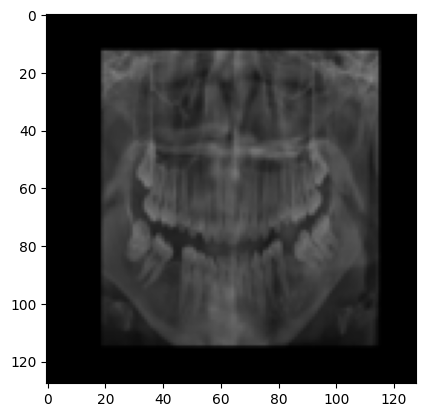

In [ ]:
n = 2
print(label[n])
plt.imshow(images[n])

## Funções para pré-processamento (7 tipos)

In [ ]:
def subtract_laplacian(image_gray):
    """
        Funcao responsavel por realçar uma imagem utilizando a operação de subtração com o filtro laplaciano
        Arguments:
          image_gray: np.array -- Uma matriz NumPy que representa a imagem na escala de cinza
                com a forma (num_rows, num_cols, num_channels)
        Return:
          img_enhancement: np.array -- Imagem realçada
    """
    laplacian = cv2.Laplacian(image_gray, cv2.CV_8U)
    image_enhancement = cv2.subtract(image_gray, laplacian)
    image_enhancement= cv2.subtract(image_enhancement, laplacian)
    return image_enhancement


def subtract_sobel(image_gray):
    """
        Funcao responsavel por realçar uma imagem utilizando a operação de subtração com o filtro de sobel
       Arguments:
          image_gray: np.array -- Uma matriz NumPy que representa a imagem na escala de cinza
                com a forma (num_rows, num_cols, num_channels)
        Return:
          image_enhancement: np.array -- Imagem realçada
    """
    sobelx = cv2.Sobel(image_gray, cv2.CV_8U, 1, 0, ksize=3)
    sobely = cv2.Sobel(image_gray, cv2.CV_8U, 0, 1, ksize=3)
    sobel = cv2.bitwise_or(sobelx, sobely)
    image_enhancement = cv2.subtract(image_gray, sobel)
    return image_enhancement


def subtract_prewitt(image_gray):
    """
        Funcao responsavel por realçar uma imagem utilizando a operação de subtração com o filtro prewitt
        Arguments:
          image_gray: np.array -- Uma matriz NumPy que representa a imagem na escala de cinza
                com a forma (num_rows, num_cols, num_channels)
        Return:
          image_enhancement: np.array -- Imagem realçada
    """
    kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    prewittx = cv2.filter2D(image_gray, -1, kernelx)
    prewitty = cv2.filter2D(image_gray, -1, kernely)
    prewitt = cv2.bitwise_or(prewittx, prewitty)
    image_enhancement = cv2.subtract(image_gray, prewitt)
    return image_enhancement


def subtract_roberts(image_gray):
    """
        Funcao responsavel por realçar uma imagem utilizando a operação de subtração com o filtro roberts
        Arguments:
          image_gray: np.array -- Uma matriz NumPy que representa a imagem na escala de cinza
                com a forma (num_rows, num_cols, num_channels)
        Return:
          image_enhancement: np.array -- Imagem realçada
    """
    kernelx = np.array([[1, 0], [0, -1]])
    kernely = np.array([[0, 1], [-1, 0]])
    robertsx= cv2.filter2D(image_gray, -1, kernelx)
    robertsy = cv2.filter2D(image_gray, -1, kernely)
    roberts = cv2.bitwise_or(robertsx, robertsy)
    image_enhancement = cv2.subtract(image_gray, roberts)
    image_enhancement = cv2.subtract(image_enhancement, roberts)
    return image_enhancement


def add_tophat(image_gray):
    """
        Funcao responsavel por realçar uma imagem utilizando a operação de adição com o filtro tophat
        Arguments:
          image_gray: np.array -- Uma matriz NumPy que representa a imagem na escala de cinza
                com a forma (num_rows, num_cols, num_channels)
        Return:
          image_processed: np.array -- Imagem realçada
    """
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    image_processed = cv2.morphologyEx(image_gray, cv2.MORPH_TOPHAT, structuring_element)
    image_processed = cv2.add(image_gray, image_processed)
    return image_processed


def subtract_blackhat(image_gray):
    """
        Funcao responsavel por realçar uma imagem utilizando a operação de subtração com o filtro blackhat
        Arguments:
          image_gray: np.array -- Uma matriz NumPy que representa a imagem na escala de cinza
                com a forma (num_rows, num_cols, num_channels)
        Return:
          image_enhancement: np.array -- Imagem realçada
    """
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
    image_processed = cv2.morphologyEx(image_gray, cv2.MORPH_BLACKHAT, structuring_element)
    image_enhancement = cv2.subtract(image_gray, image_processed)
    image_enhancement = cv2.subtract(image_enhancement, image_processed)
    return image_enhancement

def gammaCorrection(image, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(image, table)

## Validação

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def score(y_test,y_pred,name):
    y_score = accuracy_score(y_test,y_pred)
    y_recall = recall_score(y_test,y_pred, average='macro')
    y_f1_score = f1_score(y_test,y_pred, average='macro')
    y_precision = precision_score(y_test,y_pred, average='macro')
    print('Acuracia: ' + str(y_score))
    print('Recall: ' + str(y_recall))
    print('F1 Score: '+ str(y_f1_score))
    print('Precisão: ' + str(y_precision))

    print('\n')
    target_names = ['Idade 3–14', 'Idade 15–25', 'Idade >25']
    print('Classification Report')
    print(classification_report(y_test,y_pred,target_names=target_names))

    matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,5))
    class_labels = target_names
    sns.heatmap(matrix, annot=True, fmt="", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=class_labels, yticklabels=class_labels);
    plt.ylabel('Target');
    plt.xlabel('Output');
    all_sample_title = name
    plt.title(all_sample_title, size = 15);

## CNN

In [ ]:
def data_augmentation(X, y, batchSize,num_class,shuffle,preprocess_input):

  y = to_categorical(y,num_class)

  gen = ImageDataGenerator(rotation_range=1,
                            width_shift_range=0.08,
                            shear_range=0.3,
                            height_shift_range=0.08,
                            zoom_range=0.08,
                            vertical_flip = True,
                            horizontal_flip = True)

  image_dataset_ad = gen.flow(X, y, batch_size=batchSize,shuffle=shuffle)

  return image_dataset_ad

def no_data_augmentation(X, y, batchSize, num_class,shuffle,preprocess_input):

  y = to_categorical(y ,num_class)

  gen = ImageDataGenerator()

  image_dataset_ad = gen.flow(X, y, batch_size=batchSize,shuffle=shuffle)

  return image_dataset_ad

In [ ]:
def inceptionv3(input_shape):
  inception = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

  modelo = Sequential()
  modelo.add(inception)
  modelo.add(Flatten())
  modelo.add(Dropout(0.2))
  modelo.add(Dense(3, activation='softmax'))
  return modelo

In [ ]:
from tensorflow.keras.applications import efficientnet
def efficientnetv2b0_model(input_shape):
    base_model = efficientnet_v2.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))  # Altere o número 3 conforme o número de classes no seu problema
    return model

In [ ]:
from tensorflow.keras.applications import vgg19
def vgg19_model(input_shape):
    base_model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.5))  # Maior dropout por ser um modelo mais pesado
    model.add(Dense(3, activation='softmax'))  # Altere "3" para o número de classes do seu problema
    return model

In [ ]:
def select_model(model_name):
  if model_name=="InceptionV3":
    model = inceptionv3(input_shape)
    model.compile(loss='categorical_crossentropy',  optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model
  elif model_name=="EfficientNetV2B0":
    model = efficientnetv2b0_model(input_shape)
    model.compile(loss='categorical_crossentropy',  optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model
  elif model_name=="VGG19":
    model = vgg19_model(input_shape)
    model.compile(loss='categorical_crossentropy',  optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model


In [ ]:
input_shape=(128,128,3)
models = {
    #InceptionV3': inceptionv3(input_shape),
    #'EfficientNetV2B0': efficientnetv2b0_model(input_shape),
    'VGG19': vgg19_model(input_shape)
}

models_preprocess_input = {
    'InceptionV3': inception_v3.preprocess_input,
    'EfficientNetV2B0': efficientnet.preprocess_input,
    'VGG19': vgg19.preprocess_input,

}


images_processing = {
    'subtract_laplacian': [subtract_laplacian(image) for image in images],
    'subtract_sobel': [subtract_sobel(image) for image in images],
    'subtract_prewitt': [subtract_prewitt(image) for image in images],
    'subtract_roberts': [subtract_roberts(image) for image in images],
    'add_tophat': [add_tophat(image) for image in images],
    'subtract_blackhat': [subtract_blackhat(image) for image in images],
    'gammaCorrection': [gammaCorrection(image,3) for image in images],
    'images': images
}

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def train_proc(proc):
    print(f'Pré-processamento: {proc}')
    images = images_processing[proc]
    images = np.reshape(images, (len(images), 128, 128, 3))

    X_train, X_test, y_train, y_test = train_test_split(images, label, test_size=0.2, random_state=42)

    for model_name in models:
        print(f'---------------------------------------------------------------------------------------------------')
        print(f'Modelo: {model_name}')
        media_history = []
        std_history = []
        tempos_treinamento = []

        kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
        num_fold = 0
        for train_index, val_index in kf.split(X_train, y_train):
            x_trai, x_valid = X_train[train_index], X_train[val_index]
            y_trai, y_valid = y_train[train_index], y_train[val_index]

            data_train = data_augmentation(x_trai, y_trai , 32, 3, True, models_preprocess_input[model_name])
            data_valid = no_data_augmentation(x_valid, y_valid, 32, 3, False, models_preprocess_input[model_name])
            data_test = no_data_augmentation(X_test , y_test, 32, 3, False, models_preprocess_input[model_name])

            stepsEepoch = len(x_trai) // 32
            validationsSteps = len(x_valid) // 32
            model = select_model(model_name)

            earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
            reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=50, verbose=0,
                                               min_delta=1e-4, mode='min')

            # Definindo o caminho para salvar o modelo
            path_name = f'{proc}-{model_name}-fold{num_fold}.h5'
            checkpoint = ModelCheckpoint(f'drive/MyDrive/UFC/TCC/odonto/models/{path_name}',
                                         monitor='val_loss',
                                         verbose=0,
                                         mode='min',
                                         save_best_only=True)

            start_time = time.time()

            # Treinamento do modelo
            history = model.fit(data_train,
                                steps_per_epoch=stepsEepoch,
                                epochs=300,
                                validation_data=data_valid,
                                validation_steps=validationsSteps,
                                callbacks=[reduce_lr_loss, earlyStopping, checkpoint],  # Adicionando o checkpoint
                                verbose=1)

            elapsed_time = time.time() - start_time
            print(f'Fold: {num_fold} concluído em {elapsed_time:.2f} segundos.')

            # Salvar histórico
            hist_df = pd.DataFrame(history.history)
            hist_df['epoch'] = hist_df.index
            csv_hist_path = f'drive/MyDrive/UFC/TCC/odonto/history/{proc}_{model_name}_fold{num_fold}.csv'
            hist_df.to_csv(csv_hist_path, index=False)
            print(f'Histórico salvo em: {csv_hist_path}')

            # Salvar tempo
            tempos_treinamento.append({
                'filtro': proc,
                'modelo': model_name,
                'fold': num_fold,
                'tempo_em_segundos': elapsed_time
            })

            # Avaliação no teste
            y_pred = model.predict(data_test)
            y_pred = np.argmax(y_pred, axis=1)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            df_metrics = pd.DataFrame([{
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1
            }])
            metrics_path = f'drive/MyDrive/UFC/TCC/odonto/metrics_final/{proc}_{model_name}_fold{num_fold}.csv'
            df_metrics.to_csv(metrics_path, index=False)
            print(f'Métricas salvas em: {metrics_path}')

            # Armazena acurácia para análise por fold
            media = np.mean(history.history['val_accuracy'])
            std = np.std(history.history['val_accuracy'])
            media_history.append(media)
            std_history.append(std)
            num_fold += 1

        # Resumo
        for fold_idx, (m, s) in enumerate(zip(media_history, std_history)):
            print(f'Fold {fold_idx}: Média={m:.4f} | STD={s:.4f}')
        print(f'Média Geral: {np.mean(media_history):.4f} | STD Geral: {np.mean(std_history):.4f}')

        # Salvar tempos por modelo/filtro
        df_tempos = pd.DataFrame(tempos_treinamento)
        df_tempos.to_csv(f'drive/MyDrive/UFC/TCC/odonto/history/tempos_{proc}_{model_name}.csv', index=False)


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


# Inception


In [ ]:
train_proc('images')

Pré-processamento: images
---------------------------------------------------------------------------------------------------
Modelo: VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3802 - loss: 3.6845 - val_accuracy: 0.4297 - val_loss: 0.9811 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4375 - loss: 1.0717

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 1.0717 - val_accuracy: 0.5469 - val_loss: 0.9274 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4349 - loss: 1.0990 - val_accuracy: 0.4297 - val_loss: 1.0122 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - loss: 0.9725 - val_accuracy: 0.4375 - val_loss: 1.0195 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3493 - loss: 1.0810 - val_accuracy: 0.4297 - val_loss: 1.0023 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6250 - loss: 1.0444 - val_accuracy: 0.4297 - val_loss: 0.9979 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.3897 - loss: 1.0854 - val_accuracy: 0.4531 - val_loss: 0.9943 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5600 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/images_VGG19_fold0.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 523ms/step - accuracy: 0.3817 - loss: 3.2792 - val_accuracy: 0.4531 - val_loss: 1.0112 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.6250 - loss: 0.9056

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6250 - loss: 0.9056 - val_accuracy: 0.5547 - val_loss: 1.0087 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4670 - loss: 1.0718 - val_accuracy: 0.5469 - val_loss: 0.9929 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 0.9716 - val_accuracy: 0.5469 - val_loss: 0.9939 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4239 - loss: 1.0511 - val_accuracy: 0.4453 - val_loss: 0.9897 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 1.0461 - val_accuracy: 0.4766 - val_loss: 0.9573 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4869 - loss: 1.0042 - val_accuracy: 0.4766 - val_loss: 0.9832 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/images_VGG19_fold1.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step - accuracy: 0.4133 - loss: 2.4272 - val_accuracy: 0.4375 - val_loss: 1.0006 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.2812 - loss: 1.3072

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2812 - loss: 1.3072 - val_accuracy: 0.4297 - val_loss: 1.0115 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4246 - loss: 1.0567 - val_accuracy: 0.4219 - val_loss: 0.9859 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 0.9832 - val_accuracy: 0.4219 - val_loss: 0.9915 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4719 - loss: 1.0113 - val_accuracy: 0.4141 - val_loss: 0.9860 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4688 - loss: 1.0419 - val_accuracy: 0.4141 - val_loss: 0.9832 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.3863 - loss: 1.0098 - val_accuracy: 0.4141 - val_loss: 1.0139 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3750 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/images_VGG19_fold2.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 524ms/step - accuracy: 0.4182 - loss: 3.1262 - val_accuracy: 0.4297 - val_loss: 1.0368 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.3750 - loss: 1.0365

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3750 - loss: 1.0365 - val_accuracy: 0.4531 - val_loss: 1.0439 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4151 - loss: 1.0770 - val_accuracy: 0.4219 - val_loss: 1.0268 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - loss: 0.9964 - val_accuracy: 0.4219 - val_loss: 1.0300 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4036 - loss: 1.0675 - val_accuracy: 0.4219 - val_loss: 1.0218 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4688 - loss: 1.0515 - val_accuracy: 0.4219 - val_loss: 1.0244 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 238ms/step - accuracy: 0.3547 - loss: 1.0360 - val_accuracy: 0.4062 - val_loss: 1.0063 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5625 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/images_VGG19_fold3.csv
Fold 0: Média=0.7327 | STD=0.1297
Fold 1: Média=0.7493 | STD=0.1049
Fold 2: Média=0.6898 | STD=0.1011
Fold 3: Média=0.7287 | STD=0.1749
Média Geral: 0.7251 | STD Geral: 0.1276


In [ ]:
train_proc('subtract_laplacian')

Pré-processamento: subtract_laplacian
---------------------------------------------------------------------------------------------------
Modelo: VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 502ms/step - accuracy: 0.3904 - loss: 3.3707 - val_accuracy: 0.4531 - val_loss: 1.0318 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.2812 - loss: 1.0709

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2812 - loss: 1.0709 - val_accuracy: 0.4219 - val_loss: 1.0127 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.3862 - loss: 1.0918 - val_accuracy: 0.4688 - val_loss: 0.9688 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - loss: 1.0625 - val_accuracy: 0.5156 - val_loss: 0.9623 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4395 - loss: 1.0768 - val_accuracy: 0.4766 - val_loss: 0.9675 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - loss: 1.0247 - val_accuracy: 0.4922 - val_loss: 0.9662 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4169 - loss: 1.0400 - val_accuracy: 0.4453 - val_loss: 0.9678 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5312 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_laplacian_VGG19_fold0.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 519ms/step - accuracy: 0.3945 - loss: 2.8299 - val_accuracy: 0.5703 - val_loss: 1.0349 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.3750 - loss: 1.1278

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3750 - loss: 1.1278 - val_accuracy: 0.4453 - val_loss: 1.0391 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3540 - loss: 1.1061 - val_accuracy: 0.5391 - val_loss: 1.0195 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5625 - loss: 0.9754 - val_accuracy: 0.4453 - val_loss: 0.9996 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4499 - loss: 1.0371 - val_accuracy: 0.4141 - val_loss: 1.0271 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 1.0047 - val_accuracy: 0.4141 - val_loss: 1.0190 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4478 - loss: 1.0453 - val_accuracy: 0.5156 - val_loss: 1.0357 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_laplacian_VGG19_fold1.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 506ms/step - accuracy: 0.3352 - loss: 3.5952 - val_accuracy: 0.4219 - val_loss: 1.0183 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.3438 - loss: 1.1344

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3438 - loss: 1.1344 - val_accuracy: 0.4375 - val_loss: 1.0280 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.3468 - loss: 1.1720 - val_accuracy: 0.4922 - val_loss: 0.9895 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - loss: 0.9689 - val_accuracy: 0.4844 - val_loss: 1.0007 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5126 - loss: 1.0136 - val_accuracy: 0.5312 - val_loss: 0.9522 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 1.0167 - val_accuracy: 0.4844 - val_loss: 0.9360 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4981 - loss: 0.9294 - val_accuracy: 0.4297 - val_loss: 0.9362 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_laplacian_VGG19_fold2.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 511ms/step - accuracy: 0.3650 - loss: 3.8550 - val_accuracy: 0.4219 - val_loss: 1.0904 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.4062 - loss: 1.2469

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 1.2469 - val_accuracy: 0.4062 - val_loss: 1.0547 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3874 - loss: 1.1257 - val_accuracy: 0.4219 - val_loss: 1.0442 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5938 - loss: 0.9512 - val_accuracy: 0.4297 - val_loss: 1.0415 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4552 - loss: 1.0372 - val_accuracy: 0.4219 - val_loss: 1.0322 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 1.0735 - val_accuracy: 0.4219 - val_loss: 1.0298 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4158 - loss: 1.0370 - val_accuracy: 0.4219 - val_loss: 1.0251 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_laplacian_VGG19_fold3.csv
Fold 0: Média=0.7021 | STD=0.1297
Fold 1: Média=0.7265 | STD=0.1103
Fold 2: Média=0.6918 | STD=0.1019
Fold 3: Média=0.7510 | STD=0.1510
Média Geral: 0.7178 | STD Geral: 0.1232


In [ ]:
train_proc('subtract_sobel')

Pré-processamento: subtract_sobel
---------------------------------------------------------------------------------------------------
Modelo: VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.3519 - loss: 3.1001 - val_accuracy: 0.4297 - val_loss: 1.0119 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4688 - loss: 1.0848

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4688 - loss: 1.0848 - val_accuracy: 0.4297 - val_loss: 1.0254 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4227 - loss: 1.0988 - val_accuracy: 0.4766 - val_loss: 0.9978 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 1.0713 - val_accuracy: 0.4297 - val_loss: 1.0045 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4641 - loss: 1.0494 - val_accuracy: 0.4297 - val_loss: 1.0486 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2812 - loss: 1.2456 - val_accuracy: 0.4297 - val_loss: 0.9936 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4643 - loss: 1.0518 - val_accuracy: 0.4297 - val_loss: 0.9978 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5625 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_sobel_VGG19_fold0.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 511ms/step - accuracy: 0.4250 - loss: 2.9252 - val_accuracy: 0.3828 - val_loss: 1.0157 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.3750 - loss: 1.1676

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3750 - loss: 1.1676 - val_accuracy: 0.3984 - val_loss: 1.0388 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4610 - loss: 1.0376 - val_accuracy: 0.4453 - val_loss: 1.0096 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 1.0437 - val_accuracy: 0.3906 - val_loss: 1.0278 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.3970 - loss: 1.0261 - val_accuracy: 0.4141 - val_loss: 1.0198 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5625 - loss: 1.0073 - val_accuracy: 0.4453 - val_loss: 1.0355 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4304 - loss: 1.0561 - val_accuracy: 0.3750 - val_loss: 1.0103 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4688 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_sobel_VGG19_fold1.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 511ms/step - accuracy: 0.3597 - loss: 2.9297 - val_accuracy: 0.4297 - val_loss: 1.2023 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.3750 - loss: 1.4074

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3750 - loss: 1.4074 - val_accuracy: 0.4297 - val_loss: 1.0476 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4408 - loss: 1.0804 - val_accuracy: 0.4141 - val_loss: 1.0750 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 1.0867 - val_accuracy: 0.4297 - val_loss: 1.0718 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4226 - loss: 1.0821 - val_accuracy: 0.4297 - val_loss: 1.0555 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - loss: 1.0557 - val_accuracy: 0.4141 - val_loss: 1.0491 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4272 - loss: 1.0721 - val_accuracy: 0.4297 - val_loss: 1.0386 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2812 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_sobel_VGG19_fold2.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 514ms/step - accuracy: 0.3952 - loss: 2.8787 - val_accuracy: 0.5391 - val_loss: 1.0020 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.5312 - loss: 1.0819

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - loss: 1.0819 - val_accuracy: 0.5234 - val_loss: 0.9840 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4490 - loss: 1.0453 - val_accuracy: 0.4219 - val_loss: 1.0200 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4688 - loss: 1.0077 - val_accuracy: 0.4297 - val_loss: 0.9759 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.5084 - loss: 0.9769 - val_accuracy: 0.4219 - val_loss: 0.9805 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2188 - loss: 1.3175 - val_accuracy: 0.5078 - val_loss: 0.9117 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4544 - loss: 1.0014 - val_accuracy: 0.6328 - val_loss: 0.8399 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6562 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_sobel_VGG19_fold3.csv
Fold 0: Média=0.6991 | STD=0.1020
Fold 1: Média=0.6988 | STD=0.1378
Fold 2: Média=0.6676 | STD=0.1393
Fold 3: Média=0.7796 | STD=0.0916
Média Geral: 0.7113 | STD Geral: 0.1177


In [ ]:
train_proc('subtract_prewitt')

Pré-processamento: subtract_prewitt
---------------------------------------------------------------------------------------------------
Modelo: VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 504ms/step - accuracy: 0.3966 - loss: 2.3760 - val_accuracy: 0.4453 - val_loss: 1.0073 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4688 - loss: 0.9820

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4688 - loss: 0.9820 - val_accuracy: 0.4375 - val_loss: 0.9981 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4484 - loss: 1.0478 - val_accuracy: 0.4766 - val_loss: 1.0004 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - loss: 0.9906 - val_accuracy: 0.4375 - val_loss: 1.0006 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4298 - loss: 1.0568 - val_accuracy: 0.4297 - val_loss: 0.9703 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 0.9653 - val_accuracy: 0.4297 - val_loss: 0.9931 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.4385 - loss: 1.0416 - val_accuracy: 0.5547 - val_loss: 0.9620 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3600 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_prewitt_VGG19_fold0.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 511ms/step - accuracy: 0.3764 - loss: 2.4259 - val_accuracy: 0.4141 - val_loss: 1.1382 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.3438 - loss: 1.1475

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - loss: 1.1475 - val_accuracy: 0.4609 - val_loss: 1.0255 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3952 - loss: 1.0726 - val_accuracy: 0.4453 - val_loss: 1.0254 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 0.9958 - val_accuracy: 0.4453 - val_loss: 1.0264 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4792 - loss: 1.0275 - val_accuracy: 0.4062 - val_loss: 1.0254 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3750 - loss: 1.0943 - val_accuracy: 0.4062 - val_loss: 1.0242 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4511 - loss: 1.0325 - val_accuracy: 0.4453 - val_loss: 1.0070 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_prewitt_VGG19_fold1.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 508ms/step - accuracy: 0.3447 - loss: 3.3949 - val_accuracy: 0.4219 - val_loss: 1.0677 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4062 - loss: 1.1011

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 1.1011 - val_accuracy: 0.4219 - val_loss: 1.0559 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4525 - loss: 1.1259 - val_accuracy: 0.4219 - val_loss: 1.0976 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 1.0687 - val_accuracy: 0.4688 - val_loss: 1.0192 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4052 - loss: 1.1165 - val_accuracy: 0.5000 - val_loss: 1.0017 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4062 - loss: 1.0045 - val_accuracy: 0.4297 - val_loss: 1.0225 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4116 - loss: 1.0558 - val_accuracy: 0.5078 - val_loss: 0.9720 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_prewitt_VGG19_fold2.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 510ms/step - accuracy: 0.3409 - loss: 2.7102 - val_accuracy: 0.4062 - val_loss: 1.0310 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3750 - loss: 0.9749

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3750 - loss: 0.9749 - val_accuracy: 0.4219 - val_loss: 1.0404 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.3836 - loss: 1.0495 - val_accuracy: 0.4219 - val_loss: 1.0607 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5625 - loss: 1.0626 - val_accuracy: 0.4219 - val_loss: 1.0603 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4017 - loss: 1.0869 - val_accuracy: 0.3984 - val_loss: 1.0363 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 0.9817 - val_accuracy: 0.4141 - val_loss: 1.0338 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4527 - loss: 1.0369 - val_accuracy: 0.4219 - val_loss: 1.0213 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5000 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_prewitt_VGG19_fold3.csv
Fold 0: Média=0.7018 | STD=0.0917
Fold 1: Média=0.6740 | STD=0.1336
Fold 2: Média=0.6853 | STD=0.0949
Fold 3: Média=0.7315 | STD=0.1372
Média Geral: 0.6981 | STD Geral: 0.1143


In [ ]:
train_proc('subtract_roberts')

Pré-processamento: subtract_roberts
---------------------------------------------------------------------------------------------------
Modelo: VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 514ms/step - accuracy: 0.3208 - loss: 2.7339 - val_accuracy: 0.4922 - val_loss: 1.0205 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.4688 - loss: 1.0766

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4688 - loss: 1.0766 - val_accuracy: 0.4688 - val_loss: 0.9833 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4155 - loss: 1.1508 - val_accuracy: 0.4375 - val_loss: 0.9953 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5200 - loss: 1.1377 - val_accuracy: 0.4453 - val_loss: 0.9960 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4466 - loss: 1.0391 - val_accuracy: 0.4375 - val_loss: 1.0159 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6875 - loss: 0.9357 - val_accuracy: 0.4297 - val_loss: 1.0067 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4606 - loss: 1.0562 - val_accuracy: 0.4375 - val_loss: 0.9706 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_roberts_VGG19_fold0.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 515ms/step - accuracy: 0.3610 - loss: 3.5788 - val_accuracy: 0.4219 - val_loss: 1.0789 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.3438 - loss: 1.0943

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - loss: 1.0943 - val_accuracy: 0.4375 - val_loss: 1.1009 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4508 - loss: 1.0928 - val_accuracy: 0.4453 - val_loss: 1.0073 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4000 - loss: 1.0172 - val_accuracy: 0.5312 - val_loss: 1.0054 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.3746 - loss: 1.1083 - val_accuracy: 0.4141 - val_loss: 1.0223 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - loss: 1.1028 - val_accuracy: 0.4141 - val_loss: 1.0173 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4691 - loss: 1.0548 - val_accuracy: 0.4219 - val_loss: 1.0345 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5625 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_roberts_VGG19_fold1.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 501ms/step - accuracy: 0.4227 - loss: 4.9889 - val_accuracy: 0.3906 - val_loss: 1.0292 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.3750 - loss: 1.1705

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3750 - loss: 1.1705 - val_accuracy: 0.3828 - val_loss: 1.0300 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4210 - loss: 1.0691 - val_accuracy: 0.4219 - val_loss: 1.0048 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 1.0688 - val_accuracy: 0.4141 - val_loss: 1.0022 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4747 - loss: 1.0078 - val_accuracy: 0.4688 - val_loss: 1.0096 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5938 - loss: 0.9678 - val_accuracy: 0.4453 - val_loss: 1.0052 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4073 - loss: 1.0143 - val_accuracy: 0.4297 - val_loss: 1.0318 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3200 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_roberts_VGG19_fold2.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 514ms/step - accuracy: 0.4150 - loss: 2.8177 - val_accuracy: 0.4219 - val_loss: 1.0235 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3438 - loss: 1.0936

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - loss: 1.0936 - val_accuracy: 0.4219 - val_loss: 1.0296 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4241 - loss: 1.0716 - val_accuracy: 0.4375 - val_loss: 1.0084 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5625 - loss: 1.0081 - val_accuracy: 0.4219 - val_loss: 1.0331 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4327 - loss: 1.0720 - val_accuracy: 0.4219 - val_loss: 1.0091 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - loss: 0.9698 - val_accuracy: 0.4219 - val_loss: 1.0110 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4252 - loss: 1.0352 - val_accuracy: 0.4531 - val_loss: 0.9998 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_roberts_VGG19_fold3.csv
Fold 0: Média=0.7513 | STD=0.1164
Fold 1: Média=0.6930 | STD=0.1470
Fold 2: Média=0.6705 | STD=0.1136
Fold 3: Média=0.7635 | STD=0.1479
Média Geral: 0.7196 | STD Geral: 0.1312


In [ ]:
train_proc('subtract_blackhat')

Pré-processamento: subtract_blackhat
---------------------------------------------------------------------------------------------------
Modelo: VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 509ms/step - accuracy: 0.3814 - loss: 3.2679 - val_accuracy: 0.4844 - val_loss: 1.0784 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.2188 - loss: 1.1537

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2188 - loss: 1.1537 - val_accuracy: 0.4922 - val_loss: 1.0861 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4164 - loss: 1.0955 - val_accuracy: 0.4297 - val_loss: 1.0531 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 0.9977 - val_accuracy: 0.4375 - val_loss: 1.0357 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.3786 - loss: 1.0767 - val_accuracy: 0.4531 - val_loss: 1.0459 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 1.0588 - val_accuracy: 0.4297 - val_loss: 1.0239 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4235 - loss: 1.0663 - val_accuracy: 0.4297 - val_loss: 1.0185 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_blackhat_VGG19_fold0.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 511ms/step - accuracy: 0.3547 - loss: 4.8718 - val_accuracy: 0.4531 - val_loss: 1.0351 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4062 - loss: 1.3244

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 1.3244 - val_accuracy: 0.4453 - val_loss: 1.0184 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3943 - loss: 1.0969 - val_accuracy: 0.3906 - val_loss: 0.9925 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5938 - loss: 0.9460 - val_accuracy: 0.3594 - val_loss: 0.9892 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.3996 - loss: 1.0167 - val_accuracy: 0.4297 - val_loss: 1.0098 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5625 - loss: 0.9601 - val_accuracy: 0.3906 - val_loss: 1.0040 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.4243 - loss: 1.0121 - val_accuracy: 0.4453 - val_loss: 0.9813 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4400 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_blackhat_VGG19_fold1.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 505ms/step - accuracy: 0.3626 - loss: 2.3275 - val_accuracy: 0.4219 - val_loss: 1.0461 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.3125 - loss: 1.2467

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - loss: 1.2467 - val_accuracy: 0.4219 - val_loss: 1.0766 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4052 - loss: 1.0920 - val_accuracy: 0.3984 - val_loss: 1.0563 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 1.0041 - val_accuracy: 0.3984 - val_loss: 1.0586 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4528 - loss: 1.0835 - val_accuracy: 0.4375 - val_loss: 1.0282 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5312 - loss: 1.0546 - val_accuracy: 0.4297 - val_loss: 1.0342 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4189 - loss: 1.0595 - val_accuracy: 0.4453 - val_loss: 1.0607 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4062 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_blackhat_VGG19_fold2.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step - accuracy: 0.4074 - loss: 3.2138 - val_accuracy: 0.4297 - val_loss: 1.0886 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.4375 - loss: 1.0166

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 1.0166 - val_accuracy: 0.4219 - val_loss: 1.1141 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4417 - loss: 1.1283 - val_accuracy: 0.4453 - val_loss: 1.0316 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 1.0008 - val_accuracy: 0.4297 - val_loss: 1.0331 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4390 - loss: 1.0224 - val_accuracy: 0.4219 - val_loss: 1.0426 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 1.0282 - val_accuracy: 0.4219 - val_loss: 1.0367 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4393 - loss: 1.0371 - val_accuracy: 0.4219 - val_loss: 1.0442 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3750 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/subtract_blackhat_VGG19_fold3.csv
Fold 0: Média=0.7123 | STD=0.1098
Fold 1: Média=0.7044 | STD=0.1249
Fold 2: Média=0.6963 | STD=0.1151
Fold 3: Média=0.7154 | STD=0.1574
Média Geral: 0.7071 | STD Geral: 0.1268


In [ ]:
train_proc('gammaCorrection')

Pré-processamento: gammaCorrection
---------------------------------------------------------------------------------------------------
Modelo: VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 508ms/step - accuracy: 0.3822 - loss: 4.9554 - val_accuracy: 0.4609 - val_loss: 0.9646 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.2188 - loss: 1.1871

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2188 - loss: 1.1871 - val_accuracy: 0.4453 - val_loss: 1.0084 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3993 - loss: 1.0810 - val_accuracy: 0.4297 - val_loss: 0.9676 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4688 - loss: 1.0671 - val_accuracy: 0.4531 - val_loss: 0.9716 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4099 - loss: 1.0627 - val_accuracy: 0.4531 - val_loss: 0.9934 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - loss: 1.1337 - val_accuracy: 0.4531 - val_loss: 1.0013 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4003 - loss: 1.0442 - val_accuracy: 0.4297 - val_loss: 0.9884 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/gammaCorrection_VGG19_fold0.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 522ms/step - accuracy: 0.3810 - loss: 5.2490 - val_accuracy: 0.4141 - val_loss: 1.0193 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3438 - loss: 1.1573

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3438 - loss: 1.1573 - val_accuracy: 0.4688 - val_loss: 0.9997 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.3991 - loss: 1.0769 - val_accuracy: 0.4531 - val_loss: 1.0001 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - loss: 1.1146 - val_accuracy: 0.4141 - val_loss: 1.0092 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.3890 - loss: 1.0592 - val_accuracy: 0.4297 - val_loss: 1.0055 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3438 - loss: 1.0728 - val_accuracy: 0.4453 - val_loss: 1.0052 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.4832 - loss: 1.0066 - val_accuracy: 0.4688 - val_loss: 0.9952 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4062 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/gammaCorrection_VGG19_fold1.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 508ms/step - accuracy: 0.4184 - loss: 3.3974 - val_accuracy: 0.4297 - val_loss: 1.0518 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4062 - loss: 1.0848

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 1.0848 - val_accuracy: 0.4297 - val_loss: 1.0461 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4281 - loss: 1.0908 - val_accuracy: 0.4297 - val_loss: 1.0848 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3750 - loss: 1.0669 - val_accuracy: 0.4297 - val_loss: 1.0576 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4077 - loss: 1.0858 - val_accuracy: 0.4141 - val_loss: 1.0267 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 1.0022 - val_accuracy: 0.4141 - val_loss: 1.0250 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4457 - loss: 1.0291 - val_accuracy: 0.4297 - val_loss: 1.0352 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5312 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/gammaCorrection_VGG19_fold2.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 516ms/step - accuracy: 0.3777 - loss: 3.3346 - val_accuracy: 0.4375 - val_loss: 1.0307 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.5000 - loss: 1.0669

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5000 - loss: 1.0669 - val_accuracy: 0.4141 - val_loss: 1.0373 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3759 - loss: 1.0723 - val_accuracy: 0.4219 - val_loss: 1.0665 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - loss: 1.0823 - val_accuracy: 0.3828 - val_loss: 1.0344 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.3890 - loss: 1.0786 - val_accuracy: 0.4219 - val_loss: 1.0364 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4688 - loss: 1.0254 - val_accuracy: 0.4219 - val_loss: 1.0362 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4412 - loss: 1.0459 - val_accuracy: 0.4219 - val_loss: 1.0317 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/gammaCorrection_VGG19_fold3.csv
Fold 0: Média=0.6401 | STD=0.1496
Fold 1: Média=0.6842 | STD=0.1485
Fold 2: Média=0.6294 | STD=0.1506
Fold 3: Média=0.4977 | STD=0.1029
Média Geral: 0.6129 | STD Geral: 0.1379


In [ ]:
train_proc('add_tophat')

Pré-processamento: add_tophat
---------------------------------------------------------------------------------------------------
Modelo: VGG19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 510ms/step - accuracy: 0.3412 - loss: 4.2512 - val_accuracy: 0.4297 - val_loss: 1.0780 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.4062 - loss: 1.1318

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 1.1318 - val_accuracy: 0.4531 - val_loss: 1.0538 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.4454 - loss: 1.0831 - val_accuracy: 0.5078 - val_loss: 1.0058 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - loss: 1.0802 - val_accuracy: 0.4531 - val_loss: 1.0220 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4201 - loss: 1.0860 - val_accuracy: 0.3984 - val_loss: 0.9966 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 1.1260 - val_accuracy: 0.4141 - val_loss: 0.9951 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4373 - loss: 1.0335 - val_accuracy: 0.4531 - val_loss: 0.9887 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/add_tophat_VGG19_fold0.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 503ms/step - accuracy: 0.3573 - loss: 2.9850 - val_accuracy: 0.3438 - val_loss: 1.0316 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4375 - loss: 1.1184

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4375 - loss: 1.1184 - val_accuracy: 0.4375 - val_loss: 1.0314 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4642 - loss: 1.1017 - val_accuracy: 0.4453 - val_loss: 0.9920 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3750 - loss: 1.1294 - val_accuracy: 0.4766 - val_loss: 0.9922 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4449 - loss: 1.0309 - val_accuracy: 0.4141 - val_loss: 1.0567 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - loss: 1.1264 - val_accuracy: 0.4141 - val_loss: 1.0133 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.3927 - loss: 1.0340 - val_accuracy: 0.4141 - val_loss: 1.0137 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2000 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/add_tophat_VGG19_fold1.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 505ms/step - accuracy: 0.4170 - loss: 2.8575 - val_accuracy: 0.4141 - val_loss: 1.0702 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4688 - loss: 1.0838

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4688 - loss: 1.0838 - val_accuracy: 0.4141 - val_loss: 1.0364 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4447 - loss: 1.0788 - val_accuracy: 0.4297 - val_loss: 1.0338 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3438 - loss: 1.0849 - val_accuracy: 0.4297 - val_loss: 1.0307 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.4032 - loss: 1.0589 - val_accuracy: 0.4141 - val_loss: 1.0260 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 0.9787 - val_accuracy: 0.4141 - val_loss: 1.0207 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.4111 - loss: 1.0223 - val_accuracy: 0.4141 - val_loss: 1.0142 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5000 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/add_tophat_VGG19_fold2.csv


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 501ms/step - accuracy: 0.3548 - loss: 2.7790 - val_accuracy: 0.4297 - val_loss: 1.0220 - learning_rate: 1.0000e-04
Epoch 2/300
 1/13 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4375 - loss: 1.0110

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4375 - loss: 1.0110 - val_accuracy: 0.4531 - val_loss: 1.0264 - learning_rate: 1.0000e-04
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.4618 - loss: 1.0504 - val_accuracy: 0.3984 - val_loss: 1.0131 - learning_rate: 1.0000e-04
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2812 - loss: 1.1019 - val_accuracy: 0.3906 - val_loss: 1.0073 - learning_rate: 1.0000e-04
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.3539 - loss: 1.0709 - val_accuracy: 0.5000 - val_loss: 0.9438 - learning_rate: 1.0000e-04
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3125 - loss: 1.1626 - val_accuracy: 0.5469 - val_loss: 0.9080 - learning_rate: 1.0000e-04
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - accuracy: 0.4684 - loss: 1.0110 - val_accuracy: 0.4766 - val_loss: 0.9890 - learning_rate: 1.0000e-04
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
Métricas salvas em: drive/MyDrive/UFC/TCC/odonto/metrics_final/add_tophat_VGG19_fold3.csv
Fold 0: Média=0.6622 | STD=0.1528
Fold 1: Média=0.6873 | STD=0.1610
Fold 2: Média=0.6762 | STD=0.1253
Fold 3: Média=0.7501 | STD=0.1400
Média Geral: 0.6939 | STD Geral: 0.1448
